# Example3 - Multisetup with Post Separate Estimation Re-scaling (PoSER) method

In [1]:
import os
import sys
# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyoma2.algorithms import SSIcov
from pyoma2.setup import MultiSetup_PoSER, SingleSetup

For the **PoSER** approach, after importing the necessary modules and loading the data, the next step is to create a separate instance of the single setup class for each available dataset.

In this example, we'll be working with a simulated dataset generated from a finite element model of a fictitious three-story, L-shaped building. This model was created using OpenSeesPy, and the corresponding Python script can be found in the GitHub repository. 

The exact natural frequencies of the system are: 2.63186, 2.69173, 3.43042, 8.29742, 8.42882, 10.6272, 14.0053, 14.093, 17.5741

In [2]:
# import data files
set1 = np.load("../src/pyoma2/test_data/3SL/set1.npy", allow_pickle=True)
set2 = np.load("../src/pyoma2/test_data/3SL/set2.npy", allow_pickle=True)
set3 = np.load("../src/pyoma2/test_data/3SL/set3.npy", allow_pickle=True)

# create single setup
ss1 = SingleSetup(set1, fs=100)
ss2 = SingleSetup(set2, fs=100)
ss3 = SingleSetup(set3, fs=100)

# Detrend and decimate
ss1.decimate_data(q=2)
ss2.decimate_data(q=2)
ss3.decimate_data(q=2)

The process for obtaining the modal properties from each setup remains the same as described in the example for the single setup. 

2024-09-09 00:38:01,844 - pyoma2.setup.base - INFO - Running SSIcov1... (base:128)
2024-09-09 00:38:01,846 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov_mm... (ssi:82)
2024-09-09 00:38:02,846 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:339)
100%|██████████| 81/81 [00:00<00:00, 4962.01it/s]
2024-09-09 00:38:02,897 - pyoma2.functions.ssi - INFO - Calculating modal parameters... (ssi:502)
100%|██████████| 80/80 [00:00<00:00, 348.09it/s]
2024-09-09 00:38:04,053 - pyoma2.setup.base - INFO - all done (base:107)
2024-09-09 00:38:04,053 - pyoma2.setup.base - INFO - Running SSIcov2... (base:128)
2024-09-09 00:38:04,056 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov_mm... (ssi:82)
2024-09-09 00:38:04,589 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:339)
100%|██████████| 81/81 [00:00<00:00, 11362.88it/s]
2024-09-09 00:38:04,600 - pyoma2.functions.ssi - INFO - Calculating modal parameters... (ssi:502)

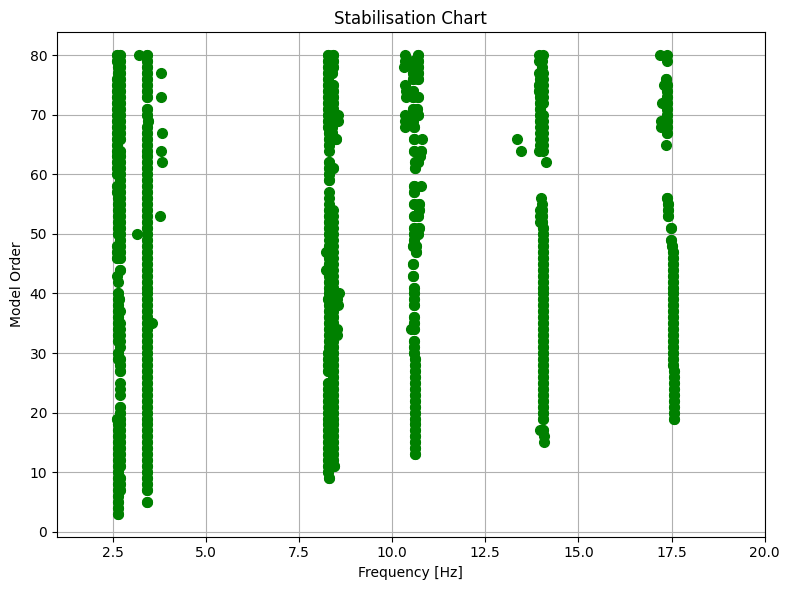

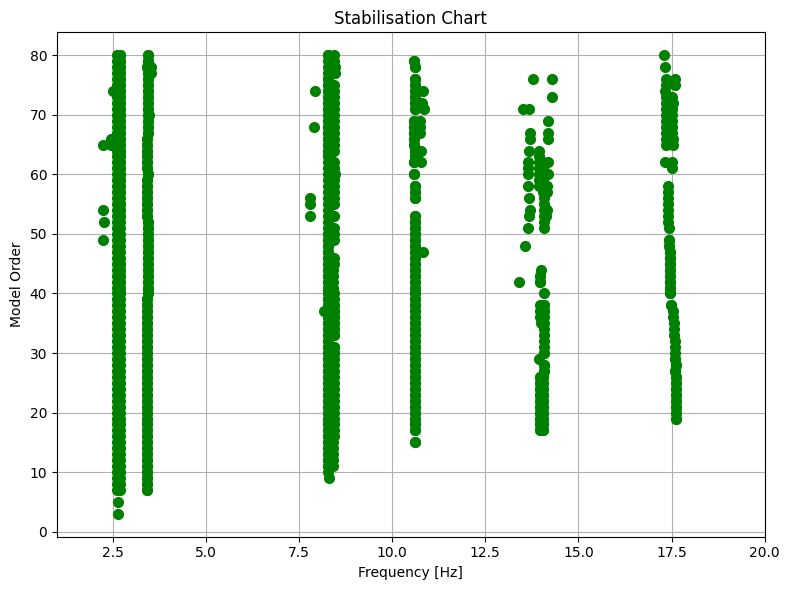

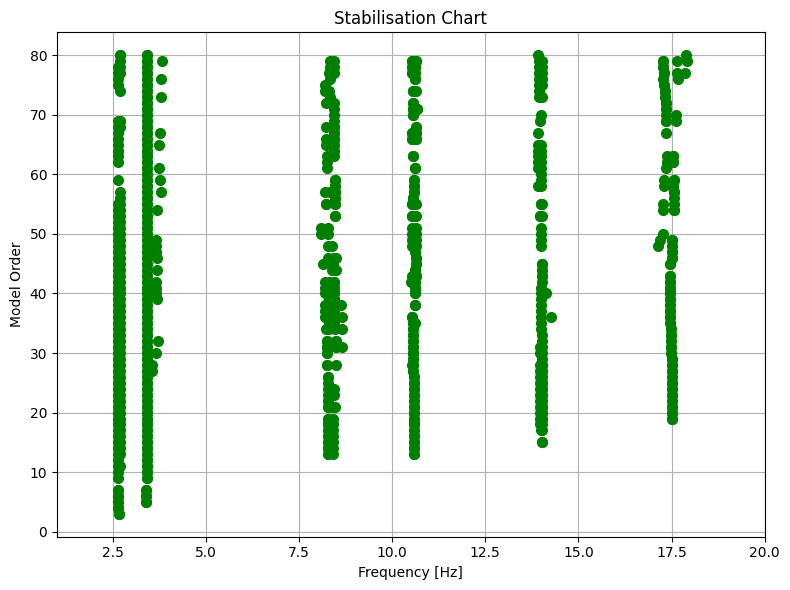

In [3]:
# Initialise the algorithms for setup 1
ssicov1 = SSIcov(name="SSIcov1", method="cov_mm", br=50, ordmax=80)
# Add algorithms to the class
ss1.add_algorithms(ssicov1)
ss1.run_all()

# Initialise the algorithms for setup 2
ssicov2 = SSIcov(name="SSIcov2", method="cov_mm", br=50, ordmax=80)
ss2.add_algorithms(ssicov2)
ss2.run_all()

# Initialise the algorithms for setup 3
ssicov3 = SSIcov(name="SSIcov3", method="cov_mm", br=50, ordmax=80)
ss3.add_algorithms(ssicov3)
ss3.run_all()

# Plot stabilisation chart
_, _ = ssicov1.plot_stab(freqlim=(1,20))
_, _ = ssicov2.plot_stab(freqlim=(1,20))
_, _ = ssicov3.plot_stab(freqlim=(1,20))

# Extract results 
ss1.mpe(
    "SSIcov1",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 14.00, 14.09, 17.57],
    order=50)
ss2.mpe(
    "SSIcov2",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 14.00, 14.09, 17.57],
    order=40)
ss3.mpe(
    "SSIcov3",
    sel_freq=[2.63, 2.69, 3.43, 8.29, 8.42, 10.62, 14.00, 14.09, 17.57],
    order=40)

After analyzing all datasets, the ```MultiSetup_PoSER``` class can be instantiated by passing the processed single setup and the lists of reference indices. Subsequently, the ```merge_results()``` method is used to combine the results.

In [4]:
# reference indices
ref_ind = [[0, 1, 2], [0, 1, 2], [0, 1, 2]]
# Creating Multi setup
msp = MultiSetup_PoSER(ref_ind=ref_ind, single_setups=[ss1, ss2, ss3])

# Merging results from single setups
result = msp.merge_results()

2024-09-09 00:38:07,037 - pyoma2.setup.multi - INFO - Merging SSIcov results (multi:225)
2024-09-09 00:38:07,037 - pyoma2.setup.multi - INFO - Merging SSIcov1 results (multi:231)
2024-09-09 00:38:07,037 - pyoma2.setup.multi - INFO - Merging SSIcov2 results (multi:231)
2024-09-09 00:38:07,039 - pyoma2.setup.multi - INFO - Merging SSIcov3 results (multi:231)


Once the class has been instantiated we can define the "global" geometry on it and then plot or animate the mode shapes

In [5]:
# Geometry 1
_geo1 = "../src/pyoma2/test_data/3SL/Geo1.xlsx"
# Geometry 2
_geo2 = "../src/pyoma2/test_data/3SL/Geo2.xlsx"

# Define geometry1
msp.def_geo1_by_file(_geo1)

# Define geometry 2
msp.def_geo2_by_file(_geo2)

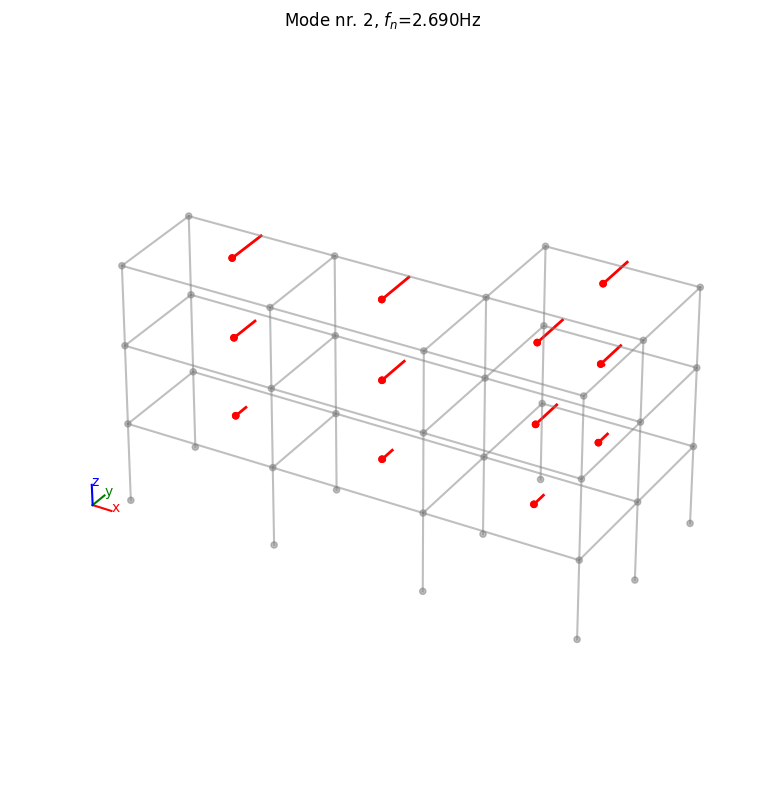

In [6]:
# define results variable
algoRes = result[SSIcov.__name__]

# Plot mode 2 (geometry 1)
_, _ = msp.plot_mode_geo1(
      algo_res=algoRes, mode_nr=2, scaleF=2)

In [7]:
# Plot mode 1 (geometry 2, pyvista)
_ = msp.plot_mode_geo2(
      algo_res=algoRes, mode_nr=1, scaleF=3, notebook=True)

Widget(value='<iframe src="http://localhost:57235/index.html?ui=P_0x17d72839df0_0&reconnect=auto" class="pyvis…

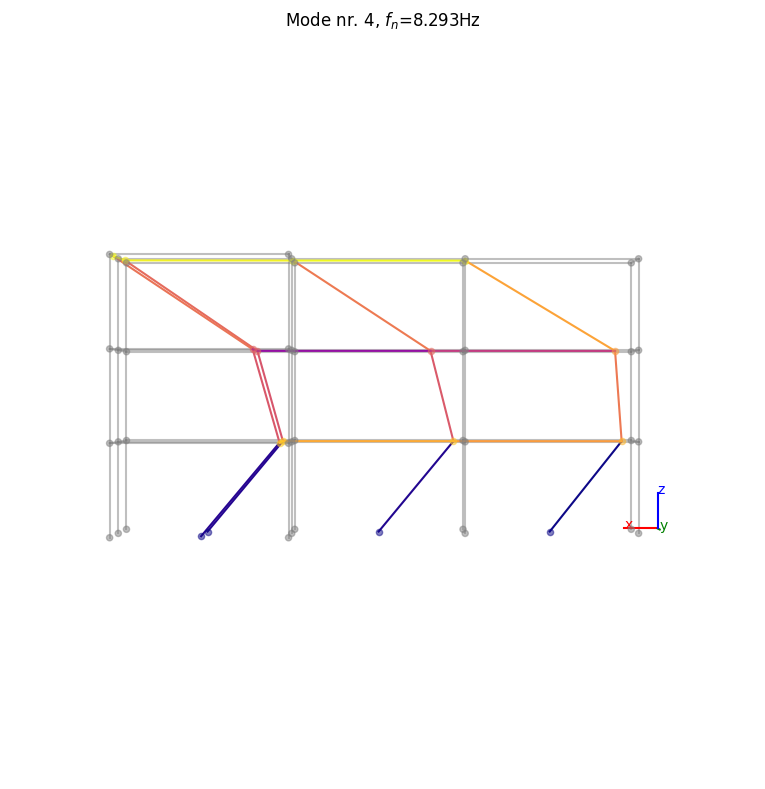

In [8]:
# Plot mode 4 (geometry 2, matplotlib)
_, _ = msp.plot_mode_geo2_mpl(
      algo_res=algoRes, mode_nr=4, view="xz", scaleF=3)

In [9]:
# Animate mode 5 (geometry 2, pyvista)
_ = msp.anim_mode_g2(
      algo_res=algoRes, mode_nr=5, scaleF=3, notebook=True)

In [10]:
algoRes.Fn

array([ 2.63245926,  2.69030811,  3.4256547 ,  8.29328508,  8.42526299,
       10.60096486, 14.03416869, 14.09286017, 17.46931459])